In [1]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt

with gzip.open('../../DataWarehouse/stMary_RRpo/21_230518_resamp_sliced125_filt_patient_stmary.pickle.gzip') as f:
    dataset = pickle.load(f)
len(dataset)

6508

In [191]:
def sma(x=None, kernel_size=5):
    return np.convolve(x, np.ones(kernel_size), 'same')/kernel_size


def range_summation(x=None, kernel_size=3):
    return np.convolve(x, np.ones(kernel_size), 'same')


def differential(x=None):
    # finite-central diff
    return np.convolve(x, np.array([-1, 0, 1]))/2


def generate_block_of_interest(x=None, type='greater', kernel_size=None, beta=None):
    boi = np.zeros(x.shape)
    moving_avg = sma(x, kernel_size)
    for i in range(len(x)):
        if type=='greater' and (x[i] >= (moving_avg[i]+beta*10)): boi[i] = 0.1
        elif type=='lesser' and (x[i] < (moving_avg[i]+beta*10)): boi[i] = 0.1

    return boi


def get_blocks(block_of_interest=None):
    blocks = []
    block = []
    if block_of_interest[0] == 0:
        is_block = False
    else:
        is_block = True

    for i in range(1, len(block_of_interest)):
        block_edge = block_of_interest[i]-block_of_interest[i-1]
        if block_edge != 0: is_block = not is_block

        if is_block == True:
            block.append(i)
        elif (is_block == False and len(block) != 0):
            blocks.append(np.asarray(block))
            block = []

    if len(block) != 0:
        blocks.append(np.asarray(block))

    return np.asarray(blocks, dtype='object')


def get_peak_valley(x=None, kernel_size=None, beta=None):
    boi_g = generate_block_of_interest(x, type='greater', kernel_size=30, beta=5)
    boi_l = generate_block_of_interest(x, type='lesser', kernel_size=30, beta=5)

    blocks_g = get_blocks(boi_g)
    blocks_l = get_blocks(boi_l)

    peak_x = []; peak_y = [];
    for block in blocks_g:
        peak_x.append(block[np.argmax(x[block])])
        peak_y.append(np.max(x[block]))

    valley_x = []; valley_y = [];
    for block in blocks_l:
        valley_x.append(block[np.argmin(x[block])])
        valley_y.append(np.min(x[block]))

    return peak_x, peak_y, valley_x, valley_y

In [254]:
idx = 2553
sig = dataset[idx][0]

In [255]:
peak_x, peak_y, valley_x, valley_y = get_peak_valley(sig, kernel_size=30, beta=5)

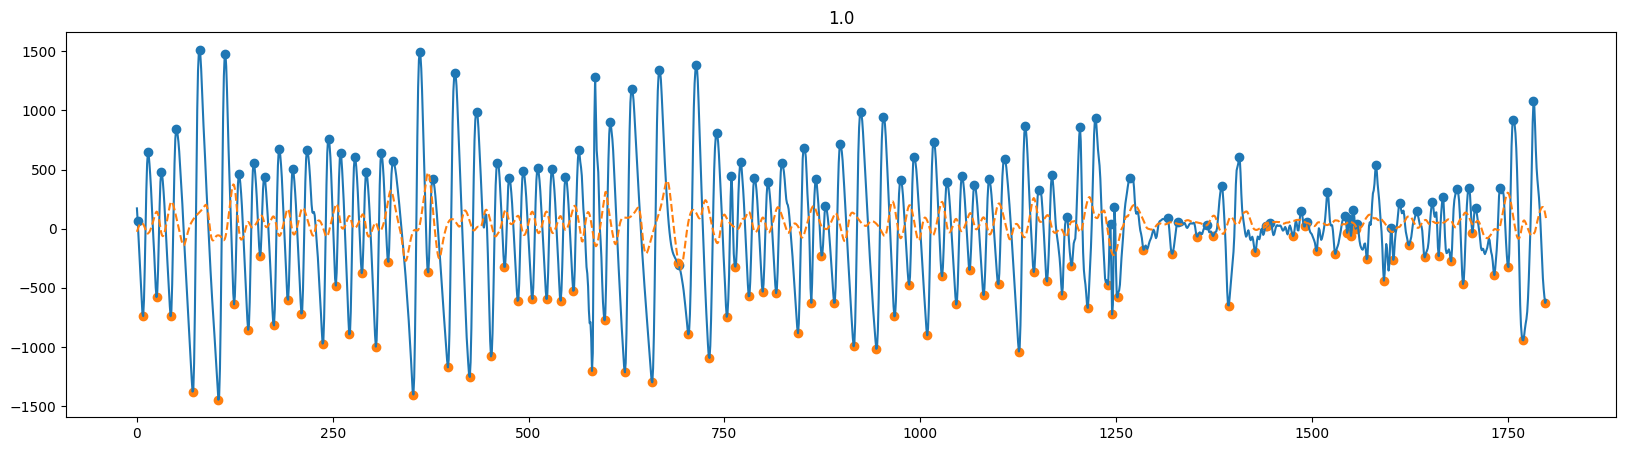

In [256]:
moving_avg = sma(sig, kernel_size=30)
plt.figure(figsize=(20,5))
plt.plot(sig)
plt.plot(moving_avg+5*10, linestyle='--')
plt.scatter(peak_x, peak_y)
plt.scatter(valley_x, valley_y)
plt.title(f'{len(peak_x)/len(peak_y)}')
# plt.xlim(0,100)
# plt_twin = plt.twinx()
# plt_twin.stem(boi, label='box_of_interest')
plt.show()

## Skewness

In [210]:
import random

In [211]:
def skewness(x):
    mu = np.mean(x)
    std = np.std(x)
    z = (x - mu)/std
    return np.mean(z**3)

In [212]:
skewnesses = np.asarray(list(map(skewness, [pleth for pleth, _ in dataset])))
print(skewnesses.shape)
print(np.where(skewnesses>=0.2)[0].shape)

(6508,)
(5240,)


In [244]:
random.sample(list(np.where(skewnesses<0.1)[0]), k=10)

[3262, 3237, 548, 2613, 3124, 5466, 5434, 2550, 3091, 2553]

## Peak and Valley Ratio(PVR)

In [218]:
pvr = []
for pleth, _ in dataset:
    peak_x, _, valley_x, _ = get_peak_valley(pleth, kernel_size=30, beta=5)
    pvr.append(len(peak_x)/len(valley_x))

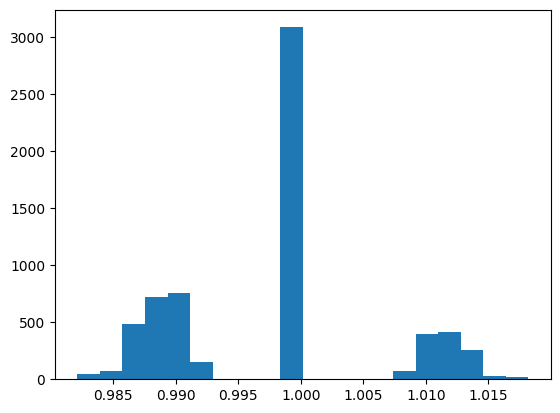

In [227]:
plt.hist(pvr, bins=20)
plt.show()